#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/wds.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
8854,25/07/2022,30.660000,30.90,30.50,30.719999,30.719999,4997664.0,1.35,1.75,125.0
8855,26/07/2022,30.930000,31.67,30.91,31.570000,31.570000,3831517.0,1.35,1.75,125.0
8856,27/07/2022,31.620001,31.92,31.33,31.500000,31.500000,3033186.0,2.50,1.75,125.0
8857,28/07/2022,32.000000,32.00,31.65,31.969999,31.969999,6012401.0,2.50,1.75,125.0
8858,29/07/2022,32.119999,32.48,31.98,31.980000,31.980000,5024961.0,2.50,1.75,125.0


In [3]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.wds.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.wds.insert_many(records)

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.wds.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.wds.delete_one(
    {'Date': last_date}
)

DELETE: 29/07/2022 31.98


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.wds.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 28/07/2022 31.969999
Previous last date in MongoDb: 28-07-2022. Today's date: 03-08-2022


In [6]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'WDS.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-28,32.000000,31.650000,32.000000,31.969999,6012401,31.969999
2022-07-29,32.480000,31.980000,32.119999,31.980000,5024961,31.980000
2022-08-01,32.900002,31.990000,32.169998,32.840000,4647762,32.840000
2022-08-02,32.709999,32.330002,32.439999,32.590000,3984735,32.590000


In [7]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-07-29,32.480000,31.980000,32.119999,31.98,5024961,31.98
2022-08-01,32.900002,31.990000,32.169998,32.84,4647762,32.84
2022-08-02,32.709999,32.330002,32.439999,32.59,3984735,32.59


In [8]:
tot=len(stock_quote)
rba=1.35
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_23800/1960956411.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_23800/1960956411.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_23800/1960956411.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,29/07/2022,32.480000,31.980000,32.119999,31.98,5024961,31.98,1.35,2.5,125
1,01/08/2022,32.900002,31.990000,32.169998,32.84,4647762,32.84,1.35,2.5,125
2,02/08/2022,32.709999,32.330002,32.439999,32.59,3984735,32.59,1.35,2.5,125


UPDATE MONGO DB

In [9]:
records=stock_quote.to_dict('records')
records

[{'Date': '29/07/2022',
  'High': 32.47999954223633,
  'Low': 31.979999542236328,
  'Open': 32.119998931884766,
  'Close': 31.979999542236328,
  'Volume': 5024961,
  'Adj Close': 31.979999542236328,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '01/08/2022',
  'High': 32.900001525878906,
  'Low': 31.989999771118164,
  'Open': 32.16999816894531,
  'Close': 32.84000015258789,
  'Volume': 4647762,
  'Adj Close': 32.84000015258789,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '02/08/2022',
  'High': 32.709999084472656,
  'Low': 32.33000183105469,
  'Open': 32.439998626708984,
  'Close': 32.59000015258789,
  'Volume': 3984735,
  'Adj Close': 32.59000015258789,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125}]

In [10]:
#INSERT NEW DATA INTO MONGODB
db.wds.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.wds.find()))

last_val = df_mongo.iloc[-20:].values
print(last_val)

[[ObjectId('62e99fdf177e6e36996be012') '6/07/2022' 31.139999 31.610001
  30.07 30.200001 30.200001 11657336.0 1.35 1.75 125.0]
 [ObjectId('62e99fdf177e6e36996be013') '7/07/2022' 30.02 30.66 30.02
  30.280001 30.280001 7264493.0 1.35 1.75 125.0]
 [ObjectId('62e99fdf177e6e36996be014') '8/07/2022' 31.120001 31.434999
  30.799999 30.799999 30.799999 7673339.0 1.35 1.75 125.0]
 [ObjectId('62e99fdf177e6e36996be015') '11/07/2022' 30.82 31.5 30.76
  30.85 30.85 4102691.0 1.35 1.75 125.0]
 [ObjectId('62e99fdf177e6e36996be016') '12/07/2022' 31.200001 31.370001
  30.9 31.0 31.0 5911332.0 1.35 1.75 125.0]
 [ObjectId('62e99fdf177e6e36996be017') '13/07/2022' 30.41 30.66 30.030001
  30.1 30.1 8945712.0 1.35 1.75 125.0]
 [ObjectId('62e99fdf177e6e36996be018') '14/07/2022' 30.219999 30.700001
  30.129999 30.57 30.57 5113948.0 1.35 1.75 125.0]
 [ObjectId('62e99fdf177e6e36996be019') '15/07/2022' 30.4 30.66 30.07
  30.629999 30.629999 6198674.0 1.35 1.75 125.0]
 [ObjectId('62e99fdf177e6e36996be01a') '18/07

In [12]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

02/08/2022 32.59000015258789


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [13]:
df_mongo = pd.DataFrame(list(db.wds.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(8694, 1)

In [14]:
data

,Close
0,1.272247
1,1.272247
2,1.272247
3,1.272247
4,1.272247
...,...
8689,31.500000
8690,31.969999
8691,31.980000
8692,32.840000


In [15]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [16]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(6956, 1)

In [17]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00363848, 0.00363848, 0.00363848, 0.00363848, 0.00363848,
       0.00363848, 0.00363848, 0.00363848, 0.00363848, 0.00363848,
       0.00363848, 0.00363848, 0.00363848, 0.00363848, 0.00363848,
       0.00363848, 0.00363848, 0.00363848, 0.00363848, 0.00363848,
       0.00363848, 0.00363848, 0.00494834, 0.00494834, 0.00494834,
       0.00494834, 0.00494834, 0.00494834, 0.00494834, 0.00494834,
       0.00494834, 0.00494834, 0.00494834, 0.00494834, 0.00494834,
       0.00494834, 0.00494834, 0.00494834, 0.00494834, 0.00494834])]
[0.004948338843979581]


# Prepare train data for LSTM model

In [18]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(6896, 60)

In [19]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(6896, 60, 1)

# Build the LSTM model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [21]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

6896/6896 [==============================] - 1143s 165ms/step - loss: 5.2802e-04


In [23]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [24]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [25]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [26]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.49725923289505547

C:\Users\antoi\AppData\Local\Temp/ipykernel_23800/2374396580.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


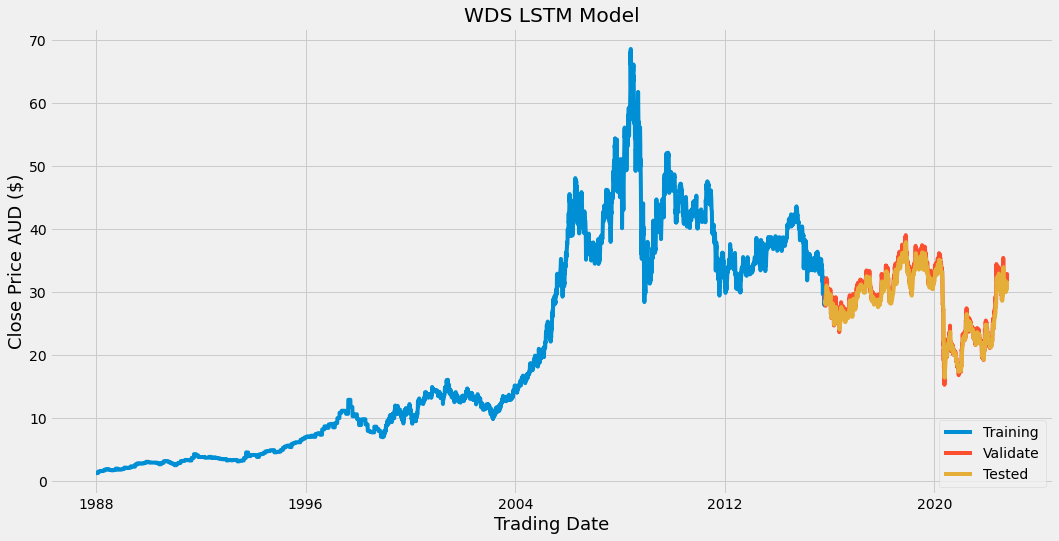

In [27]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('WDS LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
# x = np.arange(1980,2024,5)
plt.xticks([0,2000,4000,6000,8000],[1988,1996,2004,2012,2020])
plt.savefig('../static/data/images/wds_graph.png')
plt.show()

# Test data Predictions on the Model

In [28]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_23800/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
6956  29.260773    28.466400    0.794373
6957  28.421930    28.575718   -0.153788
6958  29.112741    28.296606    0.816135
6959  28.688387    28.419916    0.268471
6960  29.517361    28.337749    1.179612
...         ...          ...         ...
8689  31.500000    30.588169    0.911831
8690  31.969999    30.766527    1.203472
8691  31.980000    31.072498    0.907501
8692  32.840000    31.242226    1.597775
8693  32.590000    31.714735    0.875265

[1738 rows x 3 columns]>

In [29]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.wds.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [30]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [31]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

02/08/2022 Last close $32.59000015258789 Predicted next day share price $31


# Save the Model

In [32]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/wds_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list wds_sixty and load df

#PREDICT USING LOADED MODEL

In [33]:
from keras.models import load_model
model_in = load_model('../static/wds_model.sav')

In [34]:
# query the wds collection and load into dataframe

df_mongo = pd.DataFrame(list(db.wds.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[30.030001  ],
       [30.15      ],
       [29.34      ],
       [29.799999  ],
       [30.309999  ],
       [30.799999  ],
       [30.65      ],
       [29.58      ],
       [28.5       ],
       [28.6       ],
       [28.809999  ],
       [28.99      ],
       [28.82      ],
       [29.26      ],
       [30.        ],
       [29.690001  ],
       [29.219999  ],
       [30.709999  ],
       [31.639999  ],
       [31.65      ],
       [32.32      ],
       [33.119999  ],
       [35.07      ],
       [34.150002  ],
       [32.549999  ],
       [31.93      ],
       [31.370001  ],
       [31.41      ],
       [30.110001  ],
       [30.41      ],
       [31.440001  ],
       [30.84      ],
       [30.200001  ],
       [30.549999  ],
       [31.780001  ],
       [32.32      ],
       [31.84      ],
       [30.450001  ],
       [30.51      ],
       [31.32      ],
       [30.07      ],
       [30.02      ],
       [30.799999  ],
       [30.76      ],
       [30.9       ],
       [30

#Create a function to loop through the days input

In [35]:
from keras.models import load_model
model_in = load_model('../static/wds_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_wds(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_wds(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[32.03,
 31.97,
 31.88,
 31.79,
 31.71,
 31.64,
 31.59,
 31.54,
 31.5,
 31.47,
 31.46,
 31.44,
 31.42,
 31.42,
 31.41,
 31.4,
 31.39,
 31.4,
 31.4,
 31.4,
 31.4,
 31.4,
 31.39,
 31.38,
 31.36,
 31.34,
 31.32,
 31.3,
 31.28,
 31.27,
 31.25,
 31.24,
 31.22,
 31.21,
 31.2,
 31.19,
 31.18,
 31.16,
 31.15,
 31.14,
 31.13,
 31.12,
 31.11,
 31.1,
 31.09,
 31.09,
 31.08,
 31.07,
 31.07,
 31.07,
 31.07,
 31.07,
 31.07,
 31.07,
 31.08,
 31.08,
 31.09,
 31.09,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.11,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31.1,
 31

In [36]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  04-08-2022   Thursday
1        2  05-08-2022     Friday
2        3  08-08-2022     Monday
3        4  09-08-2022    Tuesday
4        5  10-08-2022  Wednesday
..     ...         ...        ...
203    204  16-05-2023    Tuesday
204    205  17-05-2023  Wednesday
205    206  18-05-2023   Thursday
206    207  19-05-2023     Friday
207    208  22-05-2023     Monday

[208 rows x 3 columns]>


In [37]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')


#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')

today_str=today1.strftime('%d-%m-%Y')

print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()

    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[-10:].values
    print(dates_val)


2022-07-28 00:00:00 2022-08-03 00:00:00
-7 days, 15:33:03.951550
[[ObjectId('62e112b2fb7cbba54bf62c9f') 199 '02-05-2023' 'Tuesday']
 [ObjectId('62e112b2fb7cbba54bf62ca0') 200 '03-05-2023' 'Wednesday']
 [ObjectId('62e112b2fb7cbba54bf62ca1') 201 '04-05-2023' 'Thursday']
 [ObjectId('62e112b2fb7cbba54bf62ca2') 202 '05-05-2023' 'Friday']
 [ObjectId('62e112b2fb7cbba54bf62ca3') 203 '08-05-2023' 'Monday']
 [ObjectId('62e112b2fb7cbba54bf62ca4') 204 '09-05-2023' 'Tuesday']
 [ObjectId('62e112b2fb7cbba54bf62ca5') 205 '10-05-2023' 'Wednesday']
 [ObjectId('62e112b2fb7cbba54bf62ca6') 206 '11-05-2023' 'Thursday']
 [ObjectId('62e112b2fb7cbba54bf62ca7') 207 '12-05-2023' 'Friday']
 [ObjectId('62e112b2fb7cbba54bf62ca8') 208 '15-05-2023' 'Monday']]


In [38]:
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0:,1:]
# dates_df['Count'].dtype
# dates_df_iloc = dates_df.iloc[0:180,1:]
dates_val

,Count,Date,DOW
0,1,28-07-2022,Thursday
1,2,29-07-2022,Friday
2,3,01-08-2022,Monday
3,4,02-08-2022,Tuesday
4,5,03-08-2022,Wednesday
...,...,...,...
203,204,09-05-2023,Tuesday
204,205,10-05-2023,Wednesday
205,206,11-05-2023,Thursday
206,207,12-05-2023,Friday


In [39]:
# import pandas as pd
# dates_df = pd.read_csv("../static/data/dates.csv")
# dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
# dates_df

C:\Users\antoi\AppData\Local\Temp/ipykernel_23800/401324706.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


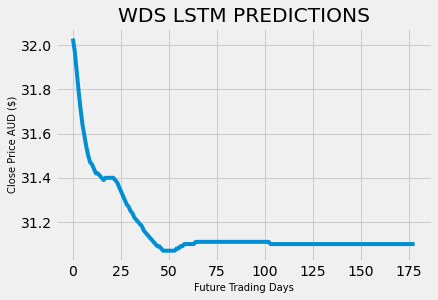

In [40]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('WDS LSTM PREDICTIONS')
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.savefig('../static/data/images/pred/wds_pred.png', bbox_inches="tight")
plt.show()

In [41]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'_id': ObjectId('62e112b2fb7cbba54bf62bd9'), 'Count': 1, 'Date': '28-07-2022', 'DOW': 'Thursday', 'Price': 32.03}


In [42]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


6956 8694 8872


In [43]:
first_val=df_mongo.iloc[:,1].values
first_date = first_val[0]
print("FIRST DATA VALUE: "+first_date.strip('/02'))

FIRST DATA VALUE: 1/02/1988


C:\Users\antoi\AppData\Local\Temp/ipykernel_23800/3908831006.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


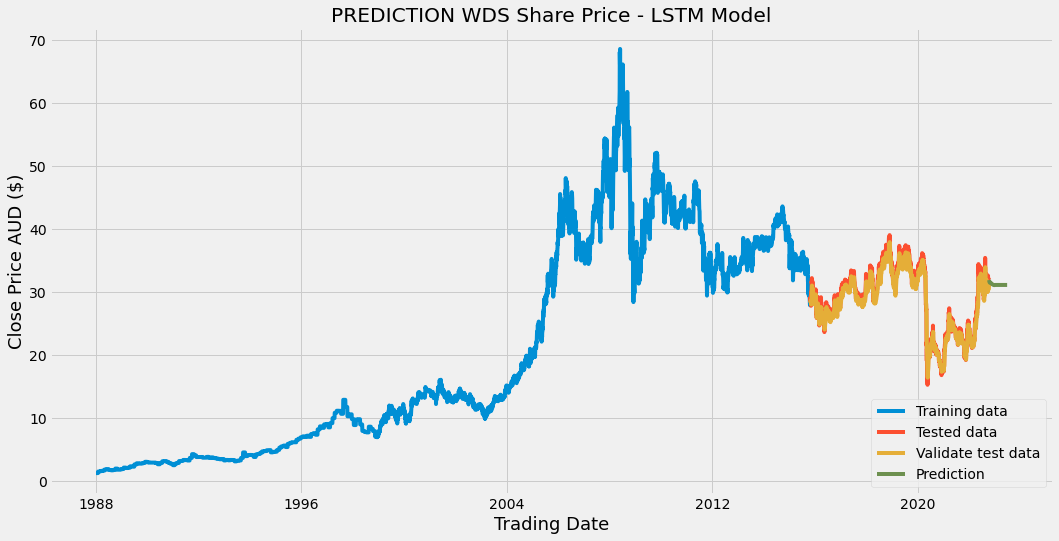

In [44]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION WDS Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
# x = np.arange(2000,2024,4)
plt.xticks([0,2000,4000,6000,8000],[1988,1996,2004,2012,2020])
plt.savefig('../static/data/images/wds_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [45]:
# Query all
name = 'WDS'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e4b499ae01b19986bd7786'), 'model': 'RFR', 'name': 'WDS', 'date': '29/07/2022', 'predicted': 41, 'actual': 31, 'differece': 10.379854935366822, 'accuracy': 96.85}
{'_id': ObjectId('62e61a127d0ca0f96027ba6d'), 'model': 'LSTM', 'name': 'WDS', 'date': '29/07/2022', 'predicted': 32, 'actual': 31.98, 'difference': 0.02, 'rmse': 0.57974}


In [46]:
# Delete a document from a collection
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e4b499ae01b19986bd7786'), 'model': 'RFR', 'name': 'WDS', 'date': '29/07/2022', 'predicted': 41, 'actual': 31, 'differece': 10.379854935366822, 'accuracy': 96.85}


In [47]:
# Set keys and values of company
name = 'WDS'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_close},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 32.59,predicted $31, actual $32.59, difference -1.5900000000000034, rmse 0.49726


In [48]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62e4b499ae01b19986bd7786'), 'model': 'RFR', 'name': 'WDS', 'date': '29/07/2022', 'predicted': 41, 'actual': 31, 'differece': 10.379854935366822, 'accuracy': 96.85}
{'_id': ObjectId('62e9a4b2177e6e36996be027'), 'model': 'LSTM', 'name': 'WDS', 'date': '02/08/2022', 'predicted': 31, 'actual': 32.59, 'difference': -1.59, 'rmse': 0.49726}


In [49]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62df8ae0427af058c4334ede'), 'model': 'RFR', 'name': 'CBA', 'date': '26/07/2022', 'predicted': 97, 'actual': 96, 'differece': 1.0204273335669143, 'accuracy': 97.43}
{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e22127c7e5ff501a0a119c'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/07/2022', 'predicted': 20.96, 'actual': 21.47, 'differece': -0.509999999999998, 'rmse': 0.17596}
{'_id': ObjectId('62e223a5553c4e8d8e53f30a'), 'model': 'LSTM', 'name': 'NHC', 'date': 

In [50]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62df8ae0427af058c4334ede'), 'model': 'RFR', 'name': 'CBA', 'date': '26/07/2022', 'predicted': 97, 'actual': 96, 'differece': 1.0204273335669143, 'accuracy': 97.43}
{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e22127c7e5ff501a0a119c'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/07/2022', 'predicted': 20.96, 'actual': 21.47, 'differece': -0.509999999999998, 'rmse': 0.17596}
{'_id': ObjectId('62e223a5553c4e8d8e53f30a'), 'model': 'LSTM', 'name': 'NHC', 'date': 